# Simulation QCQP - equivalent QP

<img src="http://media.giphy.com/media/elvaNxcznR8Fa/giphy.gif"  width="200">


In [136]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from qcqp import *
from numpy.random import randn


## Plan :

   [- QCQP](#1)
   
   [- QP](#2)
   
   [- QP vs. QCQP](#3)   

<a id="1"></a> 
 
# 1. QCQP

## Functions

Function isIncluded with QCQP algorithm

In [153]:
def IsIncluded_QCQP(cI,RI,cU,RU,n,p,q):
    i = 0
    response = False
    x = cvx.Variable(n)
    while i < q: 
        objective = -sum((x-cU[i])**2)
        constraints  = [sum((x-cI[0])**2) <= RI[0]**2]
        for k in range(1, p):
            constraints = constraints + [sum((x-cI[k])**2) <= RI[k]**2]
        for l in range(0, i):
            constraints = constraints + [sum((x-cU[l])**2) >= RU[l]**2]

        prob = cvx.Problem(cvx.Minimize(objective), constraints)  
        qcqp = QCQP(prob)
        qcqp.suggest(RANDOM)  
        #qcqp.suggest(SDR,  solver=cvx.CVXOPT)
        #qcqp.suggest(SPECTRAL)
        #f_cd = qcqp.improve(COORD_DESCENT) 
        f_cd = qcqp.improve(ADMM) 
        
        if -f_cd[0] <= RU[i]**2: 
            response = True
            i = q  
            
        i = i+1
    return response

Function IsIncluded using plot 2D

In [154]:
def IsIncluded_PLOT(cI,RI,cU,RU,p,q):
    h = .1  # step size in the mesh
    x_min, x_max =  -30, 30
    y_min, y_max = -30, 30
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    i = 0
    while i < len(xx):
        j = 0
        while j < len(yy):
            response = True
            for k in range(0,p):
                if((xx[i,j]-cI[k,0])**2+(yy[i,j]-cI[k,1])**2>RI[k]**2):
                    response = False
                    k = p
            if response == True:
                for l in range(0,q):
                    if((xx[i,j]-cU[l,0])**2+(yy[i,j]-cU[l,1])**2<=RU[l]**2):
                        response = False
                        l = q

            if response == True:
                #print(xx[i,j],yy[i,j])
                i = len(xx)
                j = len(yy)
            j= j+1
        i=i+1
    return not response

Function topology

In [155]:
def topology(cI,RI,cU,RU,n,p,q):
    c = np.concatenate((cI, cU), axis=0)
    R = np.concatenate((RI, RU), axis=0)
    response = np.ones((p+q, p+q))
    for i in range(0,p+q):
        for j in range(0,p+q):
            dist = np.sqrt(sum((c[i]-c[j])*(c[i]-c[j])))
            if dist > R[i]+R[j] : 
                response[i,j] = 0
            if dist < R[j]-R[i] : 
                response[i,j] = 2
            if dist < R[i]-R[j] : 
                response[i,j] = 3
                
    return response

Function plot 2D

In [181]:
def plot(cI,RI,cU,RU,p,q, scale = 30):
    fig, ax = plt.subplots() 
    ax.set_xlim((-scale, scale))
    ax.set_ylim((-scale, scale))

    for i in range(0, q):
        ax.add_artist(plt.Circle(list(cU[i]), RU[i], color='r',  alpha=1))
    for i in range(0, p):
        ax.add_artist(plt.Circle(list(cI[i]), RI[i], color='b', alpha=.15))

Function data generator

In [157]:
def dataGenerator(epsilon,n,p,q,diff):
    rand = np.random.normal(0, 10, n)
    cI = rand.reshape((1, n))
    RI = np.sqrt((cI*cI).sum(axis=1)) + epsilon
    
    i = 0   
    while i < p+q:
        if i < p:
            rand = np.random.normal(0, 10, n)
            c = rand.reshape((1, n))
            R = np.sqrt((c*c).sum(axis=1)) + epsilon
        if i >= p:
            rand = np.random.normal(0, 10*diff, n)
            c = rand.reshape((1, n))
            R = np.sqrt((c*c).sum(axis=1)) + epsilon/2
        concat = True
        
        for j in range(0,cI.shape[0]):
            dist = np.linalg.norm((cI[j] - c), ord=1)
            if dist < abs(RI[j]-R):
                concat = False
        
        if concat == True:
            cI = np.concatenate((cI, c), axis=0)
            RI = np.concatenate((RI, R), axis=0)
            i = i + 1
    cU = cI[0:q,]
    cI = cI[q+1:p+q+1,] 
    RU = RI[0:q]
    RI = RI[q+1:p+q+1]     
    return(cI,RI,cU,RU)

## Simple test

In [158]:
epsilon = 5
#n = nb of varialbles
n = 2
#p = nb of elements in the intersection
p = 5
#p = nb of elements in the union
q = 2

In [159]:
rand = np.random.normal(0, 10, p*n)
cI = rand.reshape((p, n))
RI = np.sqrt((cI*cI).sum(axis=1)) + epsilon

rand = np.random.normal(0, 10, q*n)
cU = rand.reshape((q, n))
RU = np.sqrt((cU*cU).sum(axis=1)) + epsilon/2

In [160]:
IsIncluded_QCQP(cI,RI,cU,RU,n,p,q)

False

In [161]:
IsIncluded_PLOT(cI,RI,cU,RU,p,q)

False

In [162]:
topology(cI,RI,cU,RU,n,p,q)

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

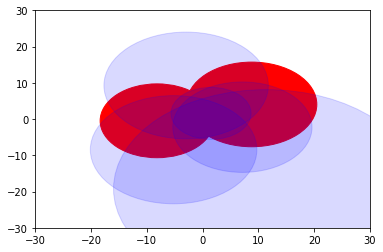

In [163]:
plot(cI,RI,cU,RU,p,q)

<img src="http://media.giphy.com/media/bvARFeSkNzIm4/giphy.gif"  width="300">

<a id="2"></a> 
 
# 2. QP

## Functions

In [164]:
from cvxopt import matrix, solvers
import cdd 
import mosek

In [165]:
def IsIncluded_QP(cI,RI,cU,RU,n,p,q):
    i = 0
    response = True
    x = cvx.Variable(n)
    while i < q: 
        #Create constraints G*x <= h
        cU2 = np.delete(cU, (i), axis=0)
        RU2 = np.delete(RU, (i), axis=0)
        h1 = RI**2 - RU[i]**2 + sum(cU[i]**2) - (cI**2).sum(axis=1)
        h2 = RU[i]**2 - RU2**2 - sum(cU[i]**2) + (cU2**2).sum(axis=1)
        h = np.concatenate((h1,h2), axis=0)
        G1 = 2*(cU[i] - cI)
        G2 = 2*(cU2 - cU[i])
        G = np.matrix(np.concatenate((G1,G2), axis=0))

        # Create variable.
        x = cvx.Variable(n)
        # Pb solution.    
        constraints = [G*x <= h]
        obj = cvx.Minimize(sum((x-cU[i])**2))
        prob = cvx.Problem(obj, constraints)
        
        if prob.solve() <RU[i]**2: #Study of the intersection circle - polyhedron   
            hh = h.reshape(G.shape[0], 1) 
            m = np.asarray(np.concatenate((hh,-G), axis=1))
            mat = cdd.Matrix(m, number_type='float')
            mat.rep_type = cdd.RepType.INEQUALITY
            poly = cdd.Polyhedron(mat)
            result = np.array(poly.get_generators())
            #print(result)
            if result.shape[0]>0:
                if (all(result[:,0] == 1) == True):#polyhedron = polytope
                    for j in range(0,result.shape[0]):
                        if (sum((result[j,1:]-cU[i])**2) > RU[i]**2):#vertex outside the ball
                            response = False
                else:
                    response = False #unbounded polyhedron
        i = i+1    
        if response == False:
            i = q
    
    if response == True: #case: partial U intersection I = emptyset
        objective = sum((x-cI[p-1])**2)
        constraints  = [sum((x-cI[0])**2) <= RI[0]**2]
        for k in range(1, p-1):
            constraints = constraints + [sum((x-cI[k])**2) <= RI[k]**2]
        probINT = cvx.Problem(cvx.Minimize(objective), constraints)  
        qcqp = QCQP(probINT)
        qcqp.suggest(RANDOM)    
        f_cd = qcqp.improve(ADMM)
        value = matrix(x.value.reshape(1,n))
        s = 0
        compteur = 0
        while s < q: 
            if np.sum((value-cU[s])**2, axis=1) >= RU[s]**2:
                compteur = compteur+1
            s = s +1
        if compteur == q:
            response == False
        
    return response

<img src="http://media.giphy.com/media/3o6Mb3Feec33LawNdm/giphy.gif"  width="300">

<a id="3"></a> 
 
# 3. QP vs. QCQP

## Exactness

In [325]:
#n = nb of variables
n = 2
#p = nb of elements in the intersection
p = 3
#p = nb of elements in the union
q = 10
diff = 1
epsilon = 50
(cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)

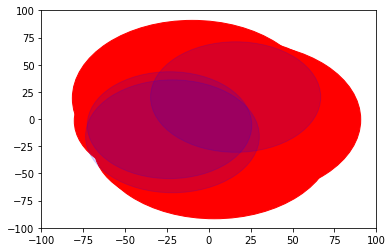

In [326]:
plot(cI,RI,cU,RU,p,q, 100)

In [262]:
#n = nb of variables
n = 2
#p = nb of elements in the intersection
p = 3
#p = nb of elements in the union
q = 2
diff = 1
epsilon = 10
diff = 1
nbQCQP = 0
nbQP = 0
nbTrue = 0

for i in range(0,100):
    (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
    Response = IsIncluded_PLOT(cI,RI,cU,RU,p,q)
    nbTrue = nbTrue + int(Response)
    nbQCQP = nbQCQP + int(IsIncluded_QCQP(cI,RI,cU,RU,n,p,q) == Response)   
    nbQP = nbQP + int(IsIncluded_QP(cI,RI,cU,RU,n,p,q) == Response)          
    print(i+1,nbTrue,nbQCQP,nbQP)

(1, 1, 1, 1)
(2, 1, 2, 2)
(3, 1, 3, 3)
(4, 1, 4, 4)
(5, 2, 5, 5)


KeyboardInterrupt: 

#### TABLE 1 OF THE PAPER : dimension 2

In [327]:
#n = nb of variables
n = 2
#p = nb of elements in the intersection
p = 3
#p = nb of elements in the union
q = 3
diff = 1
epsilon = 10
nbQCQP = 0
nbQP = 0
nbTrue = 0

for i in range(0,100):
    (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
    j = 1
    while IsIncluded_PLOT(cI,RI,cU,RU,p,q) == True:
        (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
        j = j+1
        
    Response = IsIncluded_PLOT(cI,RI,cU,RU,p,q)
    nbTrue = nbTrue + int(Response)
    nbQCQP = nbQCQP + int(IsIncluded_QCQP(cI,RI,cU,RU,n,p,q) == Response)   
    nbQP = nbQP + int(IsIncluded_QP(cI,RI,cU,RU,n,p,q) == Response)          
    print(i+1,j,nbQCQP,nbQP)

(1, 2, 0, 1)
(2, 1, 0, 2)
(3, 1, 0, 3)
(4, 2, 0, 4)
(5, 2, 0, 5)
(6, 1, 1, 6)
(7, 2, 2, 7)
(8, 2, 2, 8)
(9, 3, 3, 9)
(10, 1, 4, 10)
(11, 2, 5, 11)
(12, 5, 5, 12)
(13, 4, 5, 13)
(14, 3, 6, 14)
(15, 5, 6, 15)
(16, 2, 6, 16)
(17, 1, 6, 17)
(18, 2, 6, 18)
(19, 3, 7, 19)
(20, 1, 7, 20)
(21, 1, 8, 21)
(22, 6, 8, 22)
(23, 1, 8, 23)
(24, 4, 8, 24)
(25, 2, 8, 25)
(26, 1, 8, 26)
(27, 3, 8, 27)
(28, 8, 9, 28)
(29, 2, 10, 29)
(30, 1, 10, 30)
(31, 1, 10, 31)
(32, 6, 11, 32)
(33, 3, 12, 33)
(34, 1, 12, 34)
(35, 8, 13, 35)
(36, 7, 14, 36)
(37, 3, 14, 37)
(38, 3, 15, 38)
(39, 1, 15, 39)
(40, 4, 15, 40)
(41, 1, 15, 41)
(42, 1, 15, 42)
(43, 2, 15, 43)
(44, 1, 15, 44)
(45, 1, 16, 45)
(46, 2, 17, 46)
(47, 1, 18, 47)
(48, 3, 18, 48)
(49, 2, 19, 49)
(50, 3, 19, 50)
(51, 3, 19, 51)
(52, 1, 20, 52)
(53, 2, 21, 53)
(54, 1, 22, 54)
(55, 2, 22, 55)
(56, 6, 22, 56)
(57, 1, 23, 57)
(58, 5, 24, 58)
(59, 10, 24, 59)
(60, 3, 25, 60)
(61, 9, 25, 61)
(62, 1, 25, 62)
(63, 1, 26, 63)
(64, 8, 26, 64)
(65, 1, 26, 65)
(66, 

In [ ]:
plot(cI,RI,cU,RU,p,q)

#### TABLE 1 OF THE PAPER : dimension > 2

In [340]:
#n = nb of variables
n = 5
#p = nb of elements in the intersection
p = 3
#p = nb of elements in the union
q = 3
diff = 1
epsilon = 10
nbQCQP = 0
nbQP = 0
nbTrue = 0

for i in range(0,100):
    (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
    j = 1
    Response = IsIncluded_QP(cI,RI,cU,RU,n,p,q)
    while Response == True:
        (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
        Response = IsIncluded_QP(cI,RI,cU,RU,n,p,q)
        j = j+1
    
    nbQCQP = nbQCQP + int(IsIncluded_QCQP(cI,RI,cU,RU,n,p,q))   
    nbQP = nbQP + int(IsIncluded_QP(cI,RI,cU,RU,n,p,q))          
    print(i+1,j,nbQCQP,nbQP)

(1, 1, 0, 0)


## computationnal time

#### TABLE 2 OF THE PAPER

In [365]:
import time
n = 5
#p = nb of elements in the intersection
p = 3
#p = nb of elements in the union
q = 3
diff = 1
epsilon = 10

In [366]:
time_QP =0
time_QCQ = 0

for i in range(0,10):
    print(i)
    (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
    Response = IsIncluded_QP(cI,RI,cU,RU,n,p,q)    
    while Response == True:
        (cI,RI,cU,RU) = dataGenerator(epsilon,n,p,q,diff)
        Response = IsIncluded_QP(cI,RI,cU,RU,n,p,q)
        j = j+1
    
    time_startQP = time.clock()
    IsIncluded_QP(cI,RI,cU,RU,n,p,q)      
    time_QP = time_QP + (time.clock() - time_startQP)

    time_startQCQP = time.clock()
    IsIncluded_QCQP(cI,RI,cU,RU,n,p,q)   
    time_QCQP = time_QCQP + (time.clock() - time_startQCQP)   

print(time_QP,time_QCQP)
print(time_QCQP/time_QP)

0
1
2
3
4
5
6
7
8
9
(0.04664953415340278, 986.2315258394337)
21141.2942002
